In [1]:
import pandas as pd

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

def cart_feature_selection(df, target_column, n_features=5):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    cart = RandomForestClassifier(random_state=42)
    #cart = XGBClassifier(random_state=42)
    cart.fit(X_train, y_train)
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': cart.feature_importances_
    }).sort_values('importance', ascending=False)
    
    selected_features = feature_importance['feature'][:n_features].tolist()
    
    return selected_features



In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from deap import creator, base, tools, algorithms

def genetic_feature_selection(df, target_column, n_generations=50, population_size=50):
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", np.random.randint, 0, 2)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X.columns))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate(individual):
        selected_features = X.columns[np.array(individual, dtype=bool)]
        if len(selected_features) == 0:
            return 0,
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        scores = cross_val_score(clf, X[selected_features], y, cv=5)
        return np.mean(scores),

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=population_size)
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_generations, verbose=False)

    best_individual = tools.selBest(population, k=1)[0]
    selected_features = X.columns[np.array(best_individual, dtype=bool)].tolist()

    return selected_features

In [4]:
db_1 = pd.read_csv('New_DB_2.csv')
db_0 = pd.read_csv('New_DB_0.csv')
db_1 = db_1.drop(columns='Valor')
db_0 = db_0.drop(columns='Valor')
db_1['Fecha Evento'] = pd.to_datetime(db_1['Fecha Evento'], format='%d/%m/%Y', errors='coerce')
db_0['Fecha Evento'] = pd.to_datetime(db_0['Fecha Evento'], format='%d/%m/%Y', errors='coerce')

In [5]:
raw = pd.read_csv('data_processed.csv')
raw = raw.drop_duplicates(subset=['Latitud', 'Longitud', 'Fecha Evento'])
raw = raw.reset_index()
raw['Fecha Evento'] = pd.to_datetime(raw['Fecha Evento'], format='%d/%m/%Y', errors='coerce')

In [6]:
df_1 = pd.read_csv('test_data_1')
df_0 = pd.read_csv('test_data_0_2')
df_1 = df_1.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
df_0 = df_0.drop(columns=['Unnamed: 0'])
df_1['Valor'] = 1
df_0['Valor'] = 0
df_1['Fecha Evento'] = raw['Fecha Evento']
df_0['Fecha Evento'] = raw['Fecha Evento']
#df_1['Fecha Evento'] = pd.to_datetime(df_1['Fecha Evento'], format='%d/%m/%Y', errors='coerce')
#df_0['Fecha Evento'] = pd.to_datetime(df_0['Fecha Evento'], format='%d/%m/%Y', errors='coerce')
df_1.shape, df_0.shape


((602, 137), (602, 137))

In [7]:
df_0 = pd.merge(df_0 , db_0, on=['Latitud', 'Longitud', 'Fecha Evento'], how='inner')
df_1 = pd.merge(df_1 , db_1, on=['Latitud', 'Longitud', 'Fecha Evento'], how='inner')

In [8]:
df_1 = df_1.drop(columns=['valor_humedad_suelo2','valor_humedad_suelo3', 'valor_humedad_suelo4',
       'Tipo Remoción en masa', 'Unnamed: 0','Región', 'Comuna', 'Factor desencadenante',
       'Sistema Georeferencia', 'Cota (m.s.n.m)', 'Fecha Evento'])
df_0 = df_0.drop(columns=['valor_humedad_suelo2','valor_humedad_suelo3', 'valor_humedad_suelo4',
       'Tipo Remoción en masa', 'Unnamed: 0','Región', 'Comuna', 'Factor desencadenante',
       'Sistema Georeferencia', 'Cota (m.s.n.m)', 'Fecha Evento'])
df_1 = df_1.fillna(df_1.mean())
df_0 = df_0.fillna(df_0.mean())

In [9]:
df = pd.concat([df_0,df_1])
df = df.drop(columns=['Longitud', 'Latitud'])
df_x = df.drop(columns='Valor')
df_y = df.Valor
df_x.shape, df_y.shape

((1070, 136), (1070,))

In [185]:
# Usar CART para seleccionar características
cart_features = cart_feature_selection(df, 'Valor', n_features=5)
print("Características seleccionadas por CART:", cart_features)

# Usar algoritmo genético para seleccionar características
genetic_features = genetic_feature_selection(df, 'Valor')
print("Características seleccionadas por el algoritmo genético:", genetic_features)

Características seleccionadas por CART: ['PIRange_Bulkd.5-15cm.tif', 'PIRange_Clay.0-5cm.tif', 'ksat_30-60cm.tif', 'valor_humedad_suelo1', 'PIRange_Sand.5-15cm.tif']


c:\Users\ivo\.conda\envs\geotiff\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\ivo\.conda\envs\geotiff\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Características seleccionadas por el algoritmo genético: ['PIRange_Bulkd.0-5cm.tif', 'PIRange_Bulkd.100-200cm.tif', 'PIRange_Bulkd.15-30cm.tif', 'PIRange_Bulkd.30-60cm.tif', 'PIRange_Bulkd.60-100cm.tif', 'PIRange_Clay.0-5cm.tif', 'PIRange_Clay.15-30cm.tif', 'PIRange_Clay.30-60cm.tif', 'PIRange_Sand.0-5cm.tif', 'PIRange_Sand.100-200cm.tif', 'PIRange_Sand.60-100cm.tif', 'alpha_30-60cm.tif', 'alpha_60-100cm.tif', 'AvMoist.0-5cm.tif', 'AWC_0-5cm.tif', 'AWC_100-200cm.tif', 'AWC_5-15cm.tif', 'AWC_60-100cm.tif', 'FC.0-5cm.tif', 'FC.100-200cm.tif', 'FC.15-30cm.tif', 'FC.30-60cm.tif', 'FC.60-100cm.tif', 'ksat_15-30cm.tif', 'ksat_30-60cm.tif', 'ksat_60-100cm.tif', 'n_15-30cm.tif', 'n_5-15cm.tif', 'PWP.100-200cm.tif', 'PWP.15-30cm.tif', 'PWP.5-15cm.tif', 'theta_r_0-5cm.tif', 'theta_r_30-60cm.tif', 'theta_s_5-15cm.tif', 'theta_s_60-100cm.tif', 'alpha.100-200cm.tif', 'alpha.15-30cm.tif', 'alpha.30-60cm.tif', 'alpha.5-15cm.tif', 'alpha.60-100cm.tif', 'ksat.100-200cm.tif', 'ksat.30-60cm.tif', 'ksat.6

In [187]:
genetic_features

['PIRange_Bulkd.0-5cm.tif',
 'PIRange_Bulkd.100-200cm.tif',
 'PIRange_Bulkd.15-30cm.tif',
 'PIRange_Bulkd.30-60cm.tif',
 'PIRange_Bulkd.60-100cm.tif',
 'PIRange_Clay.0-5cm.tif',
 'PIRange_Clay.15-30cm.tif',
 'PIRange_Clay.30-60cm.tif',
 'PIRange_Sand.0-5cm.tif',
 'PIRange_Sand.100-200cm.tif',
 'PIRange_Sand.60-100cm.tif',
 'alpha_30-60cm.tif',
 'alpha_60-100cm.tif',
 'AvMoist.0-5cm.tif',
 'AWC_0-5cm.tif',
 'AWC_100-200cm.tif',
 'AWC_5-15cm.tif',
 'AWC_60-100cm.tif',
 'FC.0-5cm.tif',
 'FC.100-200cm.tif',
 'FC.15-30cm.tif',
 'FC.30-60cm.tif',
 'FC.60-100cm.tif',
 'ksat_15-30cm.tif',
 'ksat_30-60cm.tif',
 'ksat_60-100cm.tif',
 'n_15-30cm.tif',
 'n_5-15cm.tif',
 'PWP.100-200cm.tif',
 'PWP.15-30cm.tif',
 'PWP.5-15cm.tif',
 'theta_r_0-5cm.tif',
 'theta_r_30-60cm.tif',
 'theta_s_5-15cm.tif',
 'theta_s_60-100cm.tif',
 'alpha.100-200cm.tif',
 'alpha.15-30cm.tif',
 'alpha.30-60cm.tif',
 'alpha.5-15cm.tif',
 'alpha.60-100cm.tif',
 'ksat.100-200cm.tif',
 'ksat.30-60cm.tif',
 'ksat.60-100cm.tif',
 

In [48]:
cart_features = cart_feature_selection(df, 'Valor', n_features=20)
print("Características seleccionadas por CART:", cart_features)

Características seleccionadas por CART: ['PIRange_Bulkd.5-15cm.tif', 'PIRange_Clay.0-5cm.tif', 'ksat_30-60cm.tif', 'valor_humedad_suelo1', 'PIRange_Sand.5-15cm.tif', 'FC.0-5cm.tif', 'PWP.15-30cm.tif', 'alpha_60-100cm.tif', 'ksat_5-15cm.tif', 'Sand.100-200cm.tif', 'n_30-60cm.tif', 'PP', 'AWC_60-100cm.tif', 'PWP.100-200cm.tif', 'PIRange_Bulkd.60-100cm.tif', 'PIRange_Bulkd.15-30cm.tif', 'FC.30-60cm.tif', 'theta_s_100-200cm.tif', 'PIRange_Sand.100-200cm.tif', 'Bulkd.100-200cm.tif']


In [51]:
new_cart_features = cart_features
#new_cart_features.append('PP')
new_cart_features.append('slope')
#new_cart_features.append('valor_humedad_suelo1')

In [52]:
cart_features

['PIRange_Bulkd.5-15cm.tif',
 'PIRange_Clay.0-5cm.tif',
 'ksat_30-60cm.tif',
 'valor_humedad_suelo1',
 'PIRange_Sand.5-15cm.tif',
 'FC.0-5cm.tif',
 'PWP.15-30cm.tif',
 'alpha_60-100cm.tif',
 'ksat_5-15cm.tif',
 'Sand.100-200cm.tif',
 'n_30-60cm.tif',
 'PP',
 'AWC_60-100cm.tif',
 'PWP.100-200cm.tif',
 'PIRange_Bulkd.60-100cm.tif',
 'PIRange_Bulkd.15-30cm.tif',
 'FC.30-60cm.tif',
 'theta_s_100-200cm.tif',
 'PIRange_Sand.100-200cm.tif',
 'Bulkd.100-200cm.tif',
 'slope']

In [37]:
X = df[cart_features]
y = df.Valor

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 10.0]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f'Numero de entrenamiendo: {X_train.shape}, Numero de test: {X_test.shape}')
model = XGBClassifier()
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'Precisión de {acc*100}')

Numero de entrenamiendo: (856, 15), Numero de test: (214, 15)
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Precisión de 91.1214953271028


In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from deap import creator, base, tools, algorithms

def enhanced_genetic_feature_selection(df, target_column, n_generations=100, population_size=50):
    # Paso 1: Eliminar variables correlacionadas
    def remove_correlated_features(X, threshold=0.95):
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        return X.drop(to_drop, axis=1)

    # Paso 2: Aplicar CART para eliminar variables menos significativas
    def select_features_with_cart(X, y, max_features=50):
        clf = DecisionTreeClassifier(random_state=42)
        selector = SelectFromModel(clf, max_features=max_features)
        selector = selector.fit(X, y)
        return X.columns[selector.get_support()].tolist()

    # Preprocesamiento
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X = remove_correlated_features(X)
    selected_features = select_features_with_cart(X, y)
    X = X[selected_features]

    # Configuración del algoritmo genético
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", np.random.randint, 0, 2)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X.columns))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate(individual):
        selected_features = X.columns[np.array(individual, dtype=bool)]
        if len(selected_features) == 0:
            return float('inf'),
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        scores = cross_val_score(clf, X[selected_features], y, cv=5, scoring='neg_mean_squared_error')
        mse = -np.mean(scores)
        penalty = len(selected_features) / len(X.columns)
        return mse + penalty,

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=population_size)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    
    hof = tools.HallOfFame(1)
    
    final_pop, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.9, mutpb=0.1, 
                                             ngen=n_generations, stats=stats, halloffame=hof, verbose=True)

    best_individual = hof[0]
    final_selected_features = X.columns[np.array(best_individual, dtype=bool)].tolist()

    return final_selected_features, logbook



In [57]:
selected_features, logbook = enhanced_genetic_feature_selection(df, 'Valor')
print("Características seleccionadas:", selected_features)
print("Evolución del fitness:", logbook)

gen	nevals	avg     	min     
0  	50    	0.673167	0.474039
1  	50    	0.589678	0.444133
2  	43    	0.520058	0.387227
3  	42    	0.463178	0.365317
4  	41    	0.434787	0.331672
5  	50    	0.404787	0.331672
6  	44    	0.369688	0.331672
7  	46    	0.357136	0.298962
8  	46    	0.340903	0.298962
9  	50    	inf     	0.298962
10 	48    	inf     	0.298962
11 	42    	inf     	0.298962
12 	48    	0.31125 	0.298962
13 	46    	0.304754	0.298962
14 	44    	0.301261	0.298962
15 	38    	0.303379	0.298962
16 	44    	0.307599	0.298962
17 	48    	0.300577	0.298962
18 	44    	0.306667	0.298962
19 	45    	0.302978	0.298962
20 	44    	0.30394 	0.298962
21 	50    	0.302837	0.298962
22 	48    	0.30761 	0.298962
23 	47    	0.304548	0.298962
24 	44    	0.302933	0.298962
25 	48    	0.303902	0.298962
26 	40    	0.305526	0.298962
27 	42    	0.308646	0.298962
28 	41    	0.30941 	0.298962
29 	47    	0.301202	0.298962
30 	46    	0.305826	0.298962
31 	50    	0.306712	0.298962
32 	48    	0.302837	0.298962
33 	48    	0.3

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from deap import creator, base, tools, algorithms

def evaluar_cromosoma(individual, X, y, n_caracteristicas):
    # Decodificar el cromosoma
    selected_features = X.columns[np.array(individual, dtype=bool)]
    
    # Verificar restricciones
    if len(selected_features) == 0:
        return 1,  # Penalización máxima si no se selecciona ninguna característica
    
    # Entrenar el modelo
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(clf, X[selected_features], y, cv=5, scoring='accuracy')
    
    # Obtener medida de rendimiento (1 - sensibilidad para minimización)
    rendimiento = 1 - np.mean(scores)
    
    # Castigar al cromosoma basado en la cantidad de características
    penalizacion = len(selected_features) / n_caracteristicas
    
    # Devolver el valor de evaluación
    return rendimiento + penalizacion,

def seleccion_caracteristicas_genetico(df, target_column, n_generations=100, population_size=50):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    n_caracteristicas = len(X.columns)

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", np.random.randint, 0, 2)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_caracteristicas)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluar_cromosoma, X=X, y=y, n_caracteristicas=n_caracteristicas)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=population_size)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    
    logbook = tools.Logbook()
    hof = tools.HallOfFame(1)

    for gen in range(n_generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.9, mutpb=0.05 + (gen / n_generations) * 0.1)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=len(population))
        hof.update(population)
        record = stats.compile(population)
        logbook.record(gen=gen, **record)
        print(f"Generación {gen}: {record}")

    best_individual = hof[0]
    selected_features = X.columns[np.array(best_individual, dtype=bool)].tolist()

    return selected_features, logbook, hof

# Ejemplo de uso
# df = pd.read_csv("tu_dataset.csv")
# target_column = "columna_objetivo"
# mejores_caracteristicas, logbook, hof = seleccion_caracteristicas_genetico(df, target_column)
# print("Mejores características seleccionadas:", mejores_caracteristicas)
# print("Mejor fitness:", hof[0].fitness.values[0])

In [11]:
target_column = 'Valor'
mejores_caracteristicas, logbook, hof = seleccion_caracteristicas_genetico(df, target_column)
print("Mejores características seleccionadas:", mejores_caracteristicas)
print("Mejor fitness:", hof[0].fitness.values[0])

Generación 0: {'avg': 0.6674057174271576, 'min': 0.6419873556899394}
Generación 1: {'avg': 0.6437451896646509, 'min': 0.6135101704233095}
Generación 2: {'avg': 0.6231869158878506, 'min': 0.5712616822429906}
Generación 3: {'avg': 0.6019914788345244, 'min': 0.5692688290269378}
Generación 4: {'avg': 0.5803158328752062, 'min': 0.554810335349093}
Generación 5: {'avg': 0.5646341396371632, 'min': 0.5444062671797691}
Generación 6: {'avg': 0.5521017042330952, 'min': 0.5280786146234195}
Generación 7: {'avg': 0.5423636613523916, 'min': 0.5225948323254537}
Generación 8: {'avg': 0.5268798790544256, 'min': 0.5029686641011546}
Generación 9: {'avg': 0.5107251236943375, 'min': 0.49200109950522275}
Generación 10: {'avg': 0.5027517866959867, 'min': 0.47904068169323816}
Generación 11: {'avg': 0.4957025838372732, 'min': 0.47904068169323816}
Generación 12: {'avg': 0.4870354590434304, 'min': 0.46258933479934017}
Generación 13: {'avg': 0.4752061572292468, 'min': 0.45536008796041777}
Generación 14: {'avg': 0.4

In [14]:
X = df[mejores_caracteristicas]
y = df.Valor

In [16]:
mejores_caracteristicas.extend(['PP', 'slope', 'valor_humedad_suelo1'])

In [17]:
mejores_caracteristicas

['PIRange_Bulkd.30-60cm.tif',
 'PIRange_Clay.0-5cm.tif',
 'PIRange_Clay.60-100cm.tif',
 'PIRange_Sand.5-15cm.tif',
 'AWC_30-60cm.tif',
 'ksat_15-30cm.tif',
 'n_15-30cm.tif',
 'n_30-60cm.tif',
 'PWP.5-15cm.tif',
 'theta_r_0-5cm.tif',
 'theta_r_30-60cm.tif',
 'theta_r_5-15cm.tif',
 'alpha.30-60cm.tif',
 'ksat.100-200cm.tif',
 'n.30-60cm.tif',
 'n.5-15cm.tif',
 'Bulkd.60-100cm.tif',
 'Clay.100-200cm.tif',
 'Clay.15-30cm.tif',
 'Clay.60-100cm.tif',
 'Sand.30-60cm.tif',
 'Tex_Class.0-5cm.tif',
 'PP',
 'slope',
 'valor_humedad_suelo1']

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 10.0]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f'Numero de entrenamiendo: {X_train.shape}, Numero de test: {X_test.shape}')
model = XGBClassifier()
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'Precisión de {acc*100}')

Numero de entrenamiendo: (856, 22), Numero de test: (214, 22)
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Precisión de 90.65420560747664


In [26]:
data = df[mejores_caracteristicas]
data['Valor'] = df.Valor

C:\Users\ivo\AppData\Local\Temp\ipykernel_8832\3028389697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Valor'] = df.Valor


In [33]:
data_aux_1 = data[data.Valor == 1]
data_aux_0 = data[data.Valor == 0]
data_aux_0 = data_aux_0.drop(columns='Valor')
data_aux_1 = data_aux_1.drop(columns='Valor')

In [34]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

class PUBagging:
    def __init__(self, num_iterations=10, sample_ratio=1.0, random_state=42):
        self.num_iterations = num_iterations
        self.sample_ratio = sample_ratio
        self.random_state = random_state
        self.classifiers = []
        self.probabilities = None

    def fit(self, landslide_samples, unlabeled_samples):
        np.random.seed(self.random_state)

        if isinstance(landslide_samples, np.ndarray):
            landslide_samples_array = landslide_samples
        else:
            landslide_samples_array = landslide_samples.values  # Convert to numpy array if it's a DataFrame

        if isinstance(unlabeled_samples, np.ndarray):
            unlabeled_samples_array = unlabeled_samples
        else:
            unlabeled_samples_array = unlabeled_samples.values  # Convert to numpy array if it's a DataFrame

        num_samples = len(landslide_samples_array)
        num_unlabeled = len(unlabeled_samples_array)

        for _ in range(self.num_iterations):
            # Step 1: Sample equal number of unlabeled samples as non-landslide samples
            non_landslide_indices = np.random.choice(num_unlabeled, size=int(num_samples * self.sample_ratio), replace=False)
            non_landslide_samples = unlabeled_samples_array[non_landslide_indices]

            # Combine with landslide samples to form training set
            X_train = np.vstack((landslide_samples_array, non_landslide_samples))
            y_train = np.hstack((np.ones(num_samples), np.zeros(len(non_landslide_samples))))

            # Step 2: Train decision tree classifier
            clf = DecisionTreeClassifier(random_state=self.random_state)
            clf.fit(X_train, y_train)
            self.classifiers.append(clf)

            # Step 3: Predict probability of being landslide for unlabeled samples
            prob_landslide = clf.predict_proba(unlabeled_samples_array)[:, 1]

            if self.probabilities is None:
                self.probabilities = prob_landslide
            else:
                self.probabilities += prob_landslide

        # Step 4: Average probabilities over iterations
        self.probabilities /= self.num_iterations

    def predict_proba(self, unlabeled_samples):
        if isinstance(unlabeled_samples, np.ndarray):
            return self.probabilities
        else:
            return self.probabilities[:len(unlabeled_samples)]  # Return probabilities for original DataFrame

# Example usage:
if __name__ == '__main__':
    import pandas as pd
    
    # Example data (replace with your own data)
    landslide_samples = data_aux_1# Example landslide samples as DataFrame
    unlabeled_samples = data_aux_0# Example unlabeled samples as DataFrame

    # Create PU Bagging instance
    pu_bagging = PUBagging(num_iterations=5, sample_ratio=0.4, random_state=42)

    # Fit the model
    pu_bagging.fit(landslide_samples, unlabeled_samples)

    # Predict probabilities for unlabeled samples
    probabilities = pu_bagging.predict_proba(unlabeled_samples)
    print("Predicted probabilities:", probabilities)

Predicted probabilities: [0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.2 0.2 0.  0.  0.  0.  0.
 0.  0.4 0.4 0.2 0.  0.2 0.  0.  0.4 0.  0.6 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.6 0.2 0.4 0.4 0.4 0.4 0.4 0.2 0.8 0.6 0.6 0.6 0.6 0.
 0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.4 0.  0.  0.  0.  0.4 0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.4 0.  0.  0.  0.  0.
 0.  0.4 0.2 0.  0.  0.2 0.2 0.6 0.  0.  0.2 0.2 0.  0.  0.2 0.2 0.4 0.
 0.  0.  0.6 0.6 0.6 0.6 0.8 0.  0.  0.6 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.2 0.  0.
 0.  0.  0.2 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.4 0.  0.  0.  0.  0.  0.
 0.  0.  0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.4 0.4 0.6 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.2 0.2 0.  0.  0.  0.  0.  0.6 0.6 0.  0.  0.  0.  0.  0.
 0.6 0.4 0.  0.  0.  0.  0.  0.  0.  0.

In [35]:
# Suponiendo que ya tienes las probabilidades predichas por pu_bagging.predict_proba(unlabeled_samples)

# Umbral para seleccionar muestras no deslizamiento
threshold = 0.5  # Puedes ajustar este umbral según tus necesidades

# Filtrar muestras no deslizamiento por debajo del umbral
non_landslide_indices = np.where(probabilities < threshold)[0]
selected_non_landslide_samples = unlabeled_samples.iloc[non_landslide_indices]

# Ejemplo de cómo podrías utilizar las muestras seleccionadas
print("Muestras no deslizamiento seleccionadas:")
print(selected_non_landslide_samples)

Muestras no deslizamiento seleccionadas:
     PIRange_Bulkd.30-60cm.tif  PIRange_Clay.0-5cm.tif  \
0                     0.641000               22.358000   
1                     0.641000               22.358000   
2                     0.632466               23.720358   
3                     0.621000               23.513000   
4                     0.614000               25.056000   
..                         ...                     ...   
530                   0.623000               24.368000   
531                   0.619000               24.659000   
532                   0.624000               24.475998   
533                   0.623000               24.368000   
534                   0.619000               24.659000   

     PIRange_Clay.60-100cm.tif  PIRange_Sand.5-15cm.tif  AWC_30-60cm.tif  \
0                    29.312000                31.408005        61.108002   
1                    29.312000                31.408005        61.108002   
2                    32.057710    

In [36]:
selected_non_landslide_samples['Valor'] = 0
data_aux_1['Valor'] = 1

data = pd.concat([data_aux_1, selected_non_landslide_samples])
data_y = data['Valor']
data = data.drop(columns=['Valor'])

C:\Users\ivo\AppData\Local\Temp\ipykernel_8832\38701351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_non_landslide_samples['Valor'] = 0


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 10.0]
}

X_train, X_test, y_train, y_test = train_test_split(data, data_y, test_size=0.2)
print(f'Numero de entrenamiendo: {X_train.shape}, Numero de test: {X_test.shape}')
model = XGBClassifier()
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f'Precisión de {acc*100}')

Numero de entrenamiendo: (821, 25), Numero de test: (206, 25)
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Precisión de 90.29126213592234


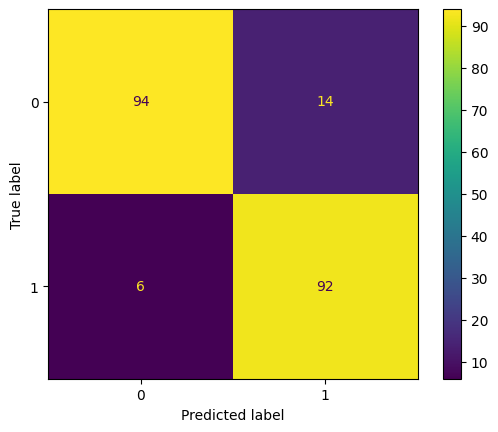

In [42]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
predictions = best_model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       108
           1       0.87      0.94      0.90        98

    accuracy                           0.90       206
   macro avg       0.90      0.90      0.90       206
weighted avg       0.91      0.90      0.90       206



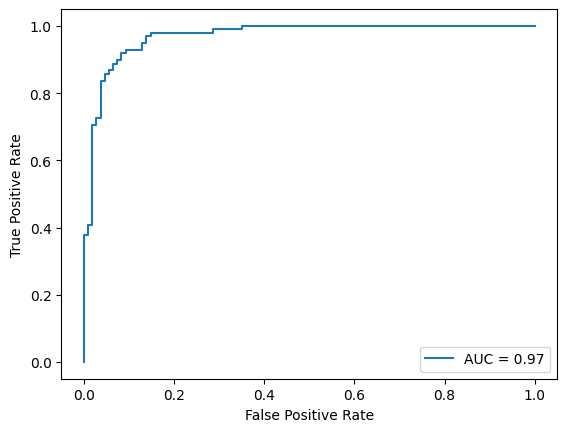

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
predictions = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,)
display.plot()
plt.show()

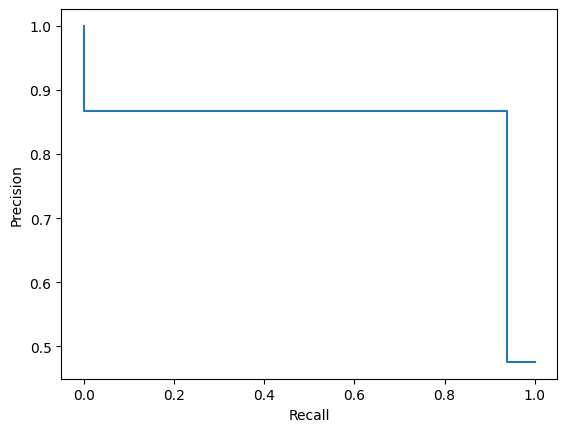

In [47]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
precision, recall, _ = precision_recall_curve(y_test, predictions)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

In [61]:
mejores_caracteristicas

['PIRange_Bulkd.30-60cm.tif',
 'PIRange_Clay.0-5cm.tif',
 'PIRange_Clay.60-100cm.tif',
 'PIRange_Sand.5-15cm.tif',
 'AWC_30-60cm.tif',
 'ksat_15-30cm.tif',
 'n_15-30cm.tif',
 'n_30-60cm.tif',
 'PWP.5-15cm.tif',
 'theta_r_0-5cm.tif',
 'theta_r_30-60cm.tif',
 'theta_r_5-15cm.tif',
 'alpha.30-60cm.tif',
 'ksat.100-200cm.tif',
 'n.30-60cm.tif',
 'n.5-15cm.tif',
 'Bulkd.60-100cm.tif',
 'Clay.100-200cm.tif',
 'Clay.15-30cm.tif',
 'Clay.60-100cm.tif',
 'Sand.30-60cm.tif',
 'Tex_Class.0-5cm.tif',
 'PP',
 'slope',
 'valor_humedad_suelo1']